# Benchmarking del mejor Orbit Emulator (retrain exp27)

Modelo ganador (sweep → retrain):
- mode = `filled`
- target_transform = `log1p`
- add_valid_flag = 1  → **in_dim = 20**
- K = 8 (Fourier features)
- width=320, depth=5
- λ_PINN ≈ 1.3045e-6

Objetivo de este notebook:
1) Resumir métricas por seed y agregadas (mean ± std).  
2) Curvas de entrenamiento/validación (bonitas, consistentes).  
3) Validación física: $u(\phi)$ y órbitas $x\text{-}y$.  
4) Benchmark adicional: error como función de $\phi$, y timing de inferencia.


In [2]:
import os, sys, time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- estilo Dracula
USE_DRACULA = True
if USE_DRACULA:
    import matplotx
    plt.style.use(matplotx.styles.dracula)

BASE = "/home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet"

CODEDIR = os.path.join(BASE, "orbit_emulator")  # <--- tu código aquí
sys.path.insert(0, CODEDIR)

RESULTS_CSV = os.path.join(BASE, "tables", "results.csv")  # <--- tu csv real
CKPT_DIR = os.path.join(BASE, "ckpt")                      # <--- tu ckpt real

OUT_FIGS = os.path.join(BASE, "out", "figs_dracula")
OUT_TAB  = os.path.join(BASE, "out", "tables")
os.makedirs(OUT_FIGS, exist_ok=True)
os.makedirs(OUT_TAB, exist_ok=True)

print("BASE:", BASE)
print("RESULTS_CSV:", RESULTS_CSV)
print("CKPT_DIR:", CKPT_DIR)
print("OUT_FIGS:", OUT_FIGS)
print("OUT_TAB:", OUT_TAB)


BASE: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet
RESULTS_CSV: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/tables/results.csv
CKPT_DIR: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/ckpt
OUT_FIGS: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/out/figs_dracula
OUT_TAB: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/out/tables


# 1. Resultados por seed (tabla reproducible)

`train_one.py` guarda `results.csv` con hiperparámetros y métricas:
- best_val (validación en target space)
- test_mse (test en target space)
- ckpt_path (ruta original en cluster)

Aquí lo usamos para:
- ordenar por desempeño
- sacar mean ± std
- crear un CSV “limpio” para slides/paper


In [3]:
df = pd.read_csv(RESULTS_CSV)

def local_ckpt(exp_id):
    return os.path.join(CKPT_DIR, f"best_{exp_id}.pt")

df["ckpt_path_local"] = df["exp_id"].apply(local_ckpt)

# sanity
print(df[["exp_id","seed","test_mse","best_val","ckpt_path_local"]].to_string(index=False))


      exp_id  seed  test_mse  best_val                                                                 ckpt_path_local
re27_seed150   150  0.002598  0.002608 /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/ckpt/best_re27_seed150.pt
re27_seed151   151  0.002862  0.002874 /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/ckpt/best_re27_seed151.pt
re27_seed152   152  0.002817  0.002894 /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/ckpt/best_re27_seed152.pt


In [4]:
from orbit_emulator import (
    load_model_from_ckpt,
    bcrit,
    u_phi_general,
    predict_u,
)

def orbit_xy(phi, u, Rs=1.0):
    phi = np.asarray(phi, float)
    u = np.asarray(u, float)
    r = np.where(np.isfinite(u) & (u > 0), Rs/u, np.nan)
    return r*np.cos(phi), r*np.sin(phi), r

def draw_reference(ax, Rs=1.0):
    th = np.linspace(0, 2*np.pi, 600)
    ax.plot(Rs*np.cos(th), Rs*np.sin(th), ":", lw=1, label="r = Rs")
    ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th), "--", lw=1, label="r = 3Rs/2")
    ax.scatter([0],[0], s=15)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25)

def make_cases(Rs=1.0):
    bc = bcrit(Rs)
    return [
        ("A_crit_out", bc, 2/3 + 0.12, dict(branch=None, region=None)),
        ("A_crit_in",  bc, 2/3 - 0.12, dict(branch=None, region=None)),
        ("B_incoming", 0.98*bc, 0.40, dict(branch="incoming", region=None)),
        ("B_outgoing", 0.98*bc, 0.90, dict(branch="outgoing", region=None)),
        ("C_scatter",  1.004*bc, 0.15, dict(branch=None, region="scatter")),
        ("C_inner",    1.004*bc, 0.92, dict(branch=None, region="inner")),
    ]


In [5]:
best = df.iloc[0]
exp_id = best["exp_id"]
ckpt_path = best["ckpt_path_local"]

print("Using:", exp_id, ckpt_path)

model, ckpt = load_model_from_ckpt(ckpt_path, map_location="cpu")

# usa los mismos settings del entrenamiento ganador
K = int(best.get("K", 8))
ADD_VALID_FLAG = bool(int(best.get("add_valid_flag", 1)))
TARGET_TF = str(best.get("target_transform", "log1p"))

Rs = 1.0
phi_max = 6.3
nphi = 2200
phi = np.linspace(1e-4, phi_max, nphi).astype(np.float32)

for name, b, u0, kwargs in make_cases(Rs):
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K,
                      add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

    m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)

    # u(phi)
    plt.figure(figsize=(7,4))
    plt.plot(phi[m], u_true[m], lw=2, label="analytic")
    plt.plot(phi[m], u_hat[m], "--", lw=2, label="NN")
    plt.axhline(2/3, ls="--", lw=1, c="k", alpha=0.6)
    plt.axhline(1.0, ls=":",  lw=1, c="gray", alpha=0.6)
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"$u(\phi)=R_S/r$")
    plt.title(f"{name} | {exp_id}")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIGS, f"u_phi_{name}_{exp_id}.png"), dpi=180)
    plt.close()

    # orbit xy
    xT, yT, _ = orbit_xy(phi[m], u_true[m], Rs=Rs)
    xP, yP, _ = orbit_xy(phi[m], u_hat[m], Rs=Rs)

    fig, ax = plt.subplots(figsize=(6.4,6.4))
    ax.plot(xT, yT, lw=2, label="analytic")
    ax.plot(xP, yP, "--", lw=2, label="NN")
    draw_reference(ax, Rs)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"Orbit {name} | {exp_id}")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIGS, f"orbit_xy_{name}_{exp_id}.png"), dpi=180)
    plt.close()

print("Saved figs to:", OUT_FIGS)


Using: re27_seed150 /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/ckpt/best_re27_seed150.pt


Saved figs to: /home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet/out/figs_dracula


In [6]:
tr = ckpt["train_hist"]
va = ckpt["val_hist"]
lr = ckpt["lr_hist"]

plt.figure(figsize=(7,4))
plt.plot(tr, label="train")
plt.plot(va, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE (target space)")
plt.title(f"Learning curves — {exp_id} | best_val={ckpt['best_val_loss']:.3e} @ ep={ckpt['epoch']}")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIGS, f"curve_trainval_{exp_id}.png"), dpi=180)
plt.close()

plt.figure(figsize=(7,3.5))
plt.plot(lr)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("lr")
plt.title(f"LR schedule — {exp_id}")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIGS, f"curve_lr_{exp_id}.png"), dpi=180)
plt.close()


In [7]:
cols_keep = [
    "exp_id","seed","mode","target_transform","add_valid_flag",
    "width","depth","K","batch","init_lr","weight_decay","lambda_pinn",
    "best_val","test_mse"
]
clean = df[cols_keep].copy()
clean.to_csv(os.path.join(OUT_TAB, "best_model_row.csv"), index=False)
clean


,exp_id,seed,mode,target_transform,add_valid_flag,width,depth,K,batch,init_lr,weight_decay,lambda_pinn,best_val,test_mse
0,re27_seed150,150,filled,log1p,1,320,5,8,4096,0.003754,0.000014,0.000001,0.002608,0.002598
1,re27_seed151,151,filled,log1p,1,320,5,8,4096,0.003754,0.000014,0.000001,0.002874,0.002862
2,re27_seed152,152,filled,log1p,1,320,5,8,4096,0.003754,0.000014,0.000001,0.002894,0.002817


[OK] Using exp_id=re27_seed150 | test_mse=0.00259811 | K=8 | add_valid_flag=1 | tf=log1p


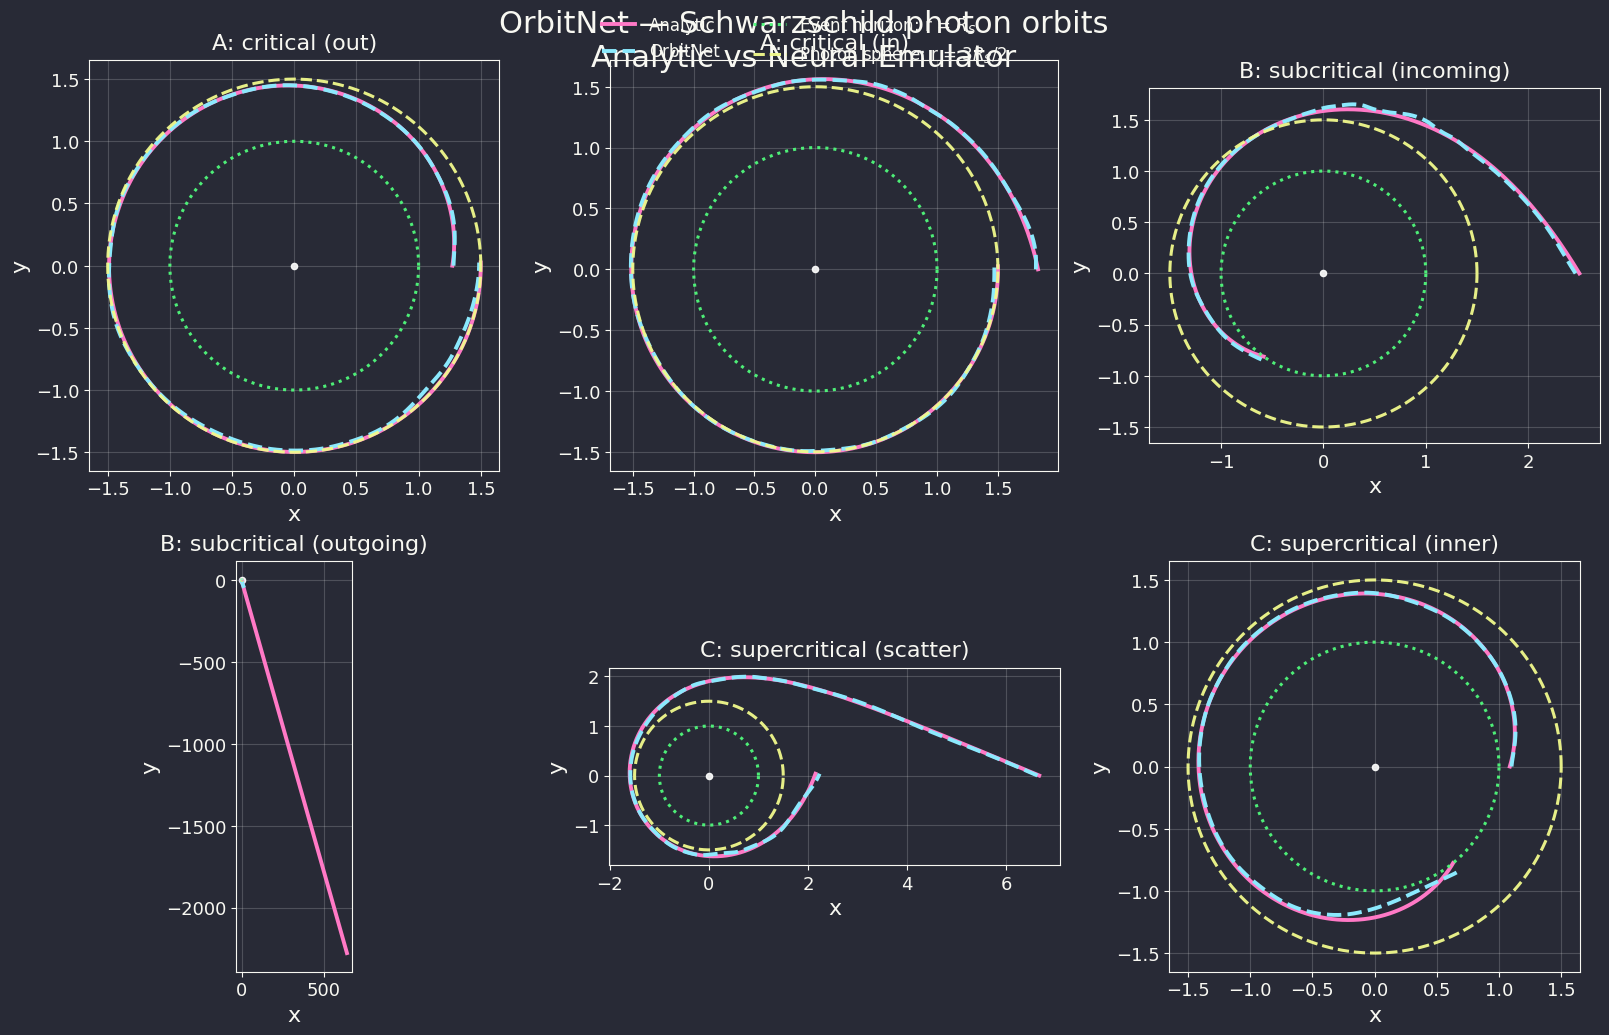

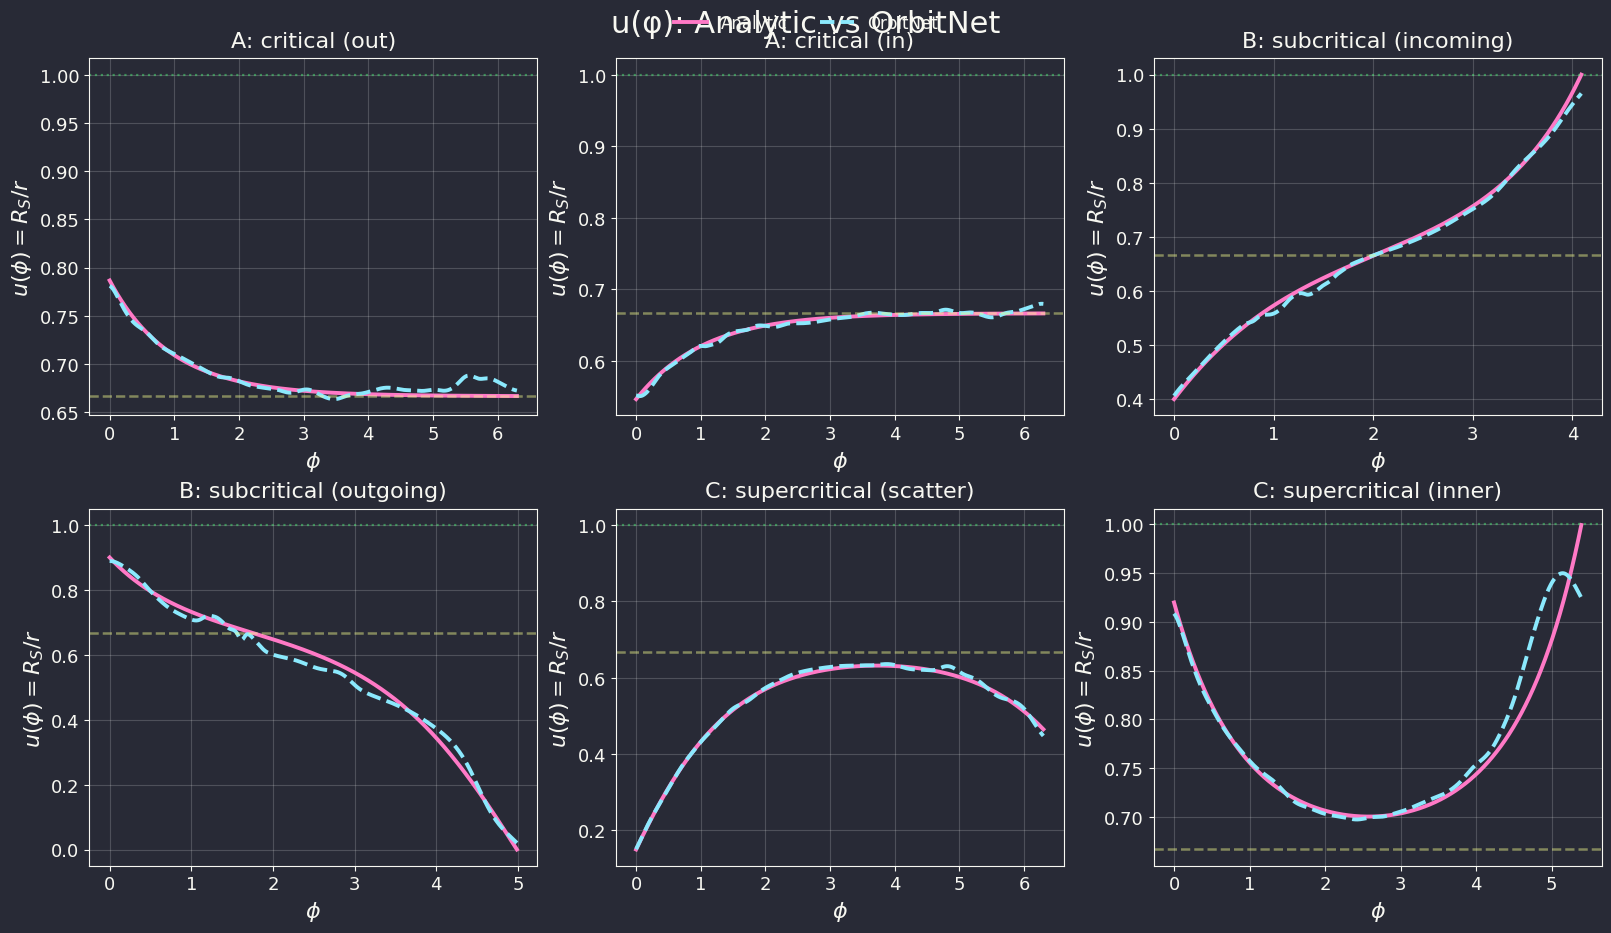

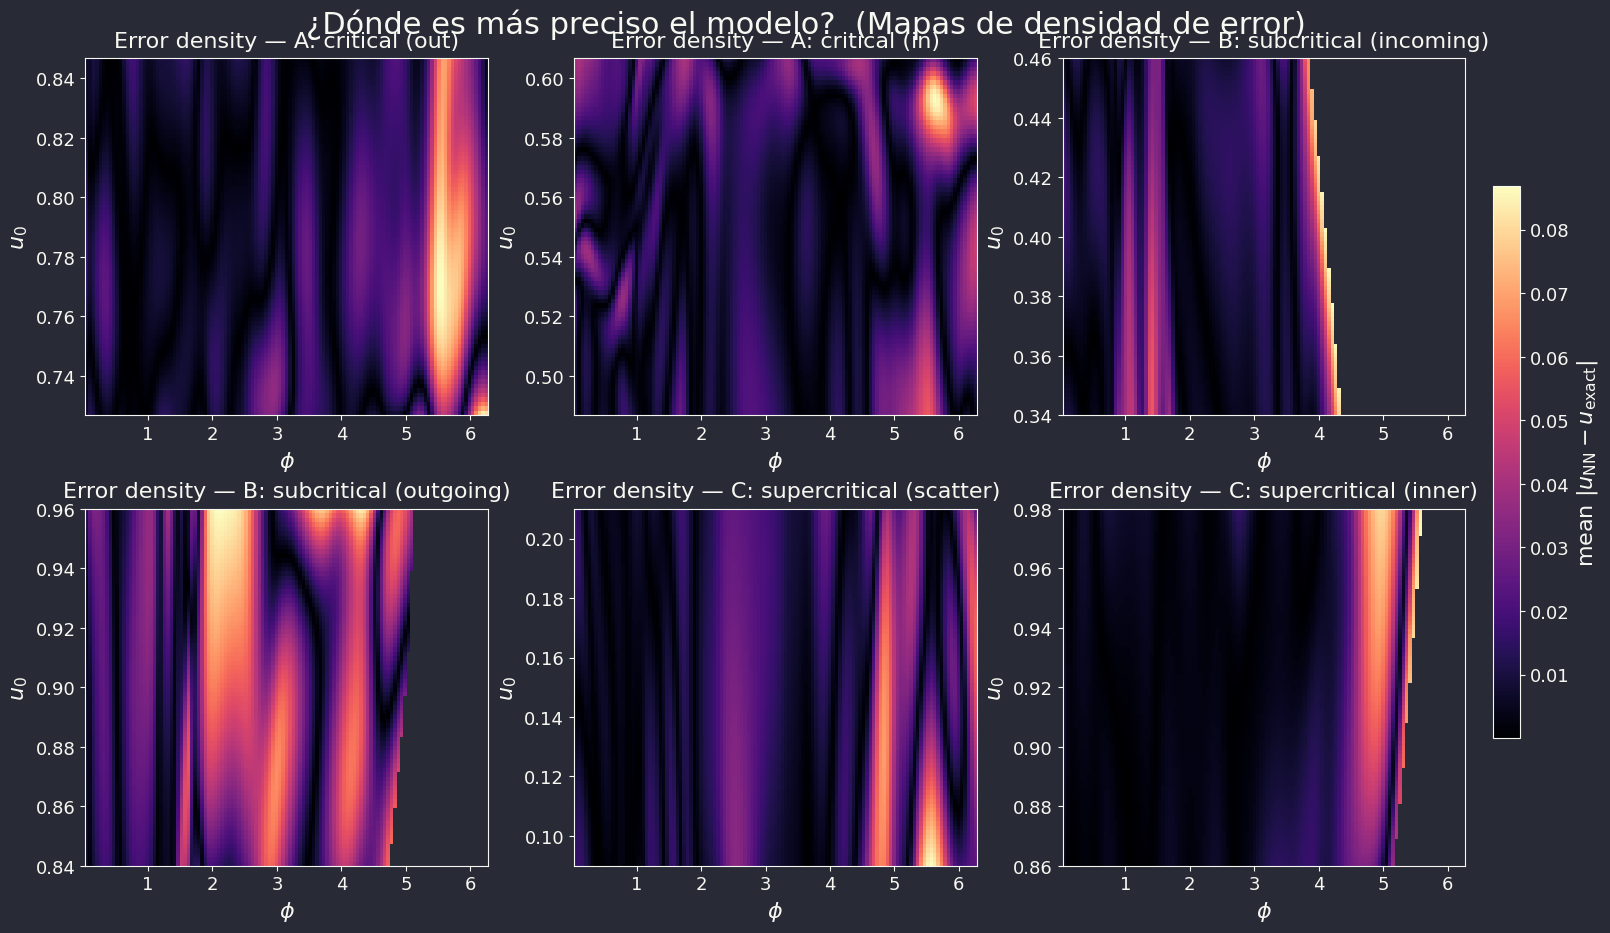

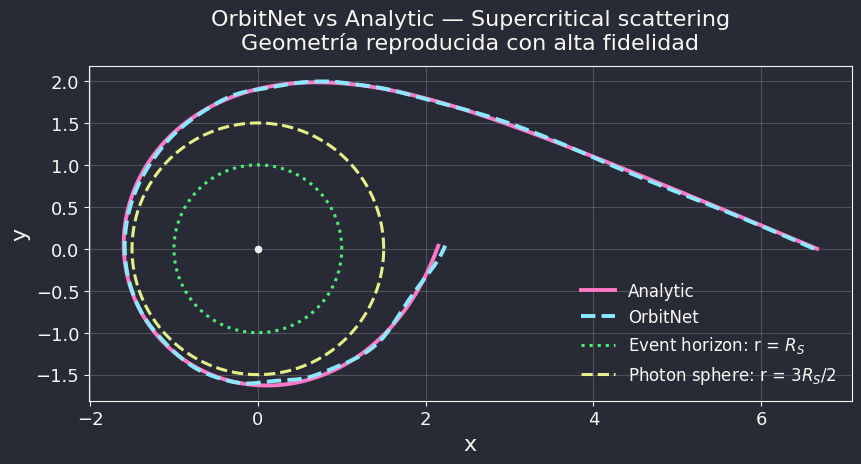

In [8]:
# =========================
# Instagram pack: OrbitNet visuals (Dracula, pretty colors, notebook display)
# =========================
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotx
plt.style.use(matplotx.styles.dracula)

# ---------- Make code importable ----------
BASE = globals().get("BASE", "/home/kingsman/Escritorio/PhD/PINN_paper/best_orbinet")
CODEDIR = globals().get("CODEDIR", os.path.join(BASE, "orbit_emulator"))
RESULTS_CSV = globals().get("RESULTS_CSV", os.path.join(BASE, "tables", "results.csv"))
CKPT_DIR = globals().get("CKPT_DIR", os.path.join(BASE, "ckpt"))
OUT_FIGS = globals().get("OUT_FIGS", os.path.join(BASE, "out", "figs_dracula"))
os.makedirs(OUT_FIGS, exist_ok=True)

if CODEDIR not in sys.path:
    sys.path.insert(0, CODEDIR)

from orbit_emulator import load_model_from_ckpt, bcrit, u_phi_general, predict_u

# ---------- Pretty palette (good on Dracula) ----------
C_ANALYTIC = "#ff79c6"  # pink/magenta
C_MODEL    = "#8be9fd"  # cyan
C_HORIZON  = "#50fa7b"  # green
C_PHOTON   = "#f1fa8c"  # yellow
C_GRID     = "white"

# ---------- Bigger readable sizes ----------
plt.rcParams.update({
    "figure.titlesize": 22,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 12,
    "lines.linewidth": 2.8,
})

def orbit_xy(phi, u, Rs=1.0):
    phi = np.asarray(phi, float)
    u = np.asarray(u, float)
    r = np.where(np.isfinite(u) & (u > 0), Rs/u, np.nan)
    return r*np.cos(phi), r*np.sin(phi), r

def draw_reference(ax, Rs=1.0):
    th = np.linspace(0, 2*np.pi, 900)

    # Event horizon (Schwarzschild radius) and photon sphere
    ax.plot(Rs*np.cos(th), Rs*np.sin(th),
            ls=":", lw=2.2, color=C_HORIZON, alpha=0.95,
            label="Event horizon: r = $R_S$")

    ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th),
            ls="--", lw=2.2, color=C_PHOTON, alpha=0.95,
            label="Photon sphere: r = $3R_S/2$")

    ax.scatter([0],[0], s=20, color="white", alpha=0.9)

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.18, color=C_GRID)

def make_cases(Rs=1.0):
    bc = bcrit(Rs)
    return [
        ("A: critical (out)", bc, 2/3 + 0.12, dict(branch=None, region=None)),
        ("A: critical (in)",  bc, 2/3 - 0.12, dict(branch=None, region=None)),
        ("B: subcritical (incoming)", 0.98*bc, 0.40, dict(branch="incoming", region=None)),
        ("B: subcritical (outgoing)", 0.98*bc, 0.90, dict(branch="outgoing", region=None)),
        ("C: supercritical (scatter)",  1.004*bc, 0.15, dict(branch=None, region="scatter")),
        ("C: supercritical (inner)",    1.004*bc, 0.92, dict(branch=None, region="inner")),
    ]

def nice_title():
    return "OrbitNet — Schwarzschild photon orbits\nAnalytic vs Neural Emulator"

# ---------- Load best model (local ckpt) ----------
df = pd.read_csv(RESULTS_CSV)

def local_ckpt(exp_id):
    return os.path.join(CKPT_DIR, f"best_{exp_id}.pt")

df["ckpt_path_local"] = df["exp_id"].apply(local_ckpt)
df = df[df["ckpt_path_local"].apply(os.path.exists)].copy()
if len(df) == 0:
    raise FileNotFoundError("No local checkpoints found in ckpt/. Expected best_<exp_id>.pt")

df = df.sort_values("test_mse").reset_index(drop=True)
best = df.iloc[0]
exp_id = best["exp_id"]
ckpt_path = best["ckpt_path_local"]

model, ckpt = load_model_from_ckpt(ckpt_path, map_location="cpu")

Rs = 1.0
K = int(best.get("K", 8))
ADD_VALID_FLAG = bool(int(best.get("add_valid_flag", 1)))
TARGET_TF = str(best.get("target_transform", "log1p"))

phi_max = 6.3
nphi = 2400
phi = np.linspace(1e-4, phi_max, nphi).astype(np.float32)
cases = make_cases(Rs)

print(f"[OK] Using exp_id={exp_id} | test_mse={best['test_mse']:.6g} | K={K} | add_valid_flag={int(ADD_VALID_FLAG)} | tf={TARGET_TF}")

# =========================================================
# (1) ORBITS GRID (XY): 2x3
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)
axes = axes.ravel()

for i, (name, b, u0, kwargs) in enumerate(cases):
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

    m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
    xT, yT, _ = orbit_xy(phi[m], u_true[m], Rs=Rs)
    xP, yP, _ = orbit_xy(phi[m], u_hat[m], Rs=Rs)

    ax = axes[i]
    ax.plot(xT, yT, color=C_ANALYTIC, label="Analytic")
    ax.plot(xP, yP, "--", color=C_MODEL, label="OrbitNet")
    draw_reference(ax, Rs=Rs)
    ax.set_title(name, pad=8)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# A single clean legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
fig.suptitle(nice_title(), y=1.02)

# Optional save (comment/uncomment)
# out1 = os.path.join(OUT_FIGS, f"IG_orbits_grid_{exp_id}.png")
# fig.savefig(out1, dpi=220)

plt.show()

# =========================================================
# (2) u(phi) GRID: 2x3
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)
axes = axes.ravel()

for i, (name, b, u0, kwargs) in enumerate(cases):
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

    m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
    ax = axes[i]
    ax.plot(phi[m], u_true[m], color=C_ANALYTIC, label="Analytic")
    ax.plot(phi[m], u_hat[m], "--", color=C_MODEL, label="OrbitNet")

    ax.axhline(2/3, ls="--", lw=1.8, color=C_PHOTON, alpha=0.45)
    ax.axhline(1.0, ls=":",  lw=1.6, color=C_HORIZON, alpha=0.45)

    ax.set_title(name, pad=8)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$u(\phi)=R_S/r$")
    ax.grid(True, alpha=0.18, color=C_GRID)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
fig.suptitle("u(φ): Analytic vs OrbitNet", y=1.02)

# Optional save
# out2 = os.path.join(OUT_FIGS, f"IG_u_phi_grid_{exp_id}.png")
# fig.savefig(out2, dpi=220)

plt.show()

# =========================================================
# (3) ERROR HEATMAPS: (phi, u0) -> mean |u_pred - u_true|
#     Colorbar robust + not cropped
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)
axes = axes.ravel()

phi_bins = np.linspace(phi.min(), phi.max(), 120)
phi_cent = 0.5*(phi_bins[:-1] + phi_bins[1:])

im_last = None
for i, (name, b, u0_nom, kwargs) in enumerate(cases):
    if "critical" in name.lower():
        du = 0.06
    elif "inner" in name.lower():
        du = 0.04
    else:
        du = 0.10

    u0_grid = np.linspace(max(0.02, u0_nom-du), min(0.98, u0_nom+du), 80)
    E = np.full((len(u0_grid), len(phi_cent)), np.nan, dtype=float)

    for j, u0 in enumerate(u0_grid):
        try:
            u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
        except Exception:
            continue
        u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

        m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
        if m.sum() < 80:
            continue

        err = np.abs(u_hat[m] - u_true[m])
        phm = phi[m]

        # bin by phi
        for kbin in range(len(phi_cent)):
            lo, hi = phi_bins[kbin], phi_bins[kbin+1]
            mm = (phm >= lo) & (phm < hi)
            if mm.any():
                E[j, kbin] = float(np.mean(err[mm]))

    ax = axes[i]
    im_last = ax.imshow(
        E,
        origin="lower",
        aspect="auto",
        extent=[phi_cent.min(), phi_cent.max(), u0_grid.min(), u0_grid.max()],
        interpolation="nearest",
        cmap="magma",  # looks great on dark backgrounds
    )
    ax.set_title(f"Error density — {name}", pad=8)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$u_0$")

# Colorbar attached to all subplots (stable with constrained_layout)
cbar = fig.colorbar(im_last, ax=axes.tolist(), fraction=0.02, pad=0.02)
cbar.set_label(r"mean $|u_{\rm NN}-u_{\rm exact}|$")

fig.suptitle("¿Dónde es más preciso el modelo?  (Mapas de densidad de error)", y=1.02)

# Optional save
# out3 = os.path.join(OUT_FIGS, f"IG_error_heatmaps_{exp_id}.png")
# fig.savefig(out3, dpi=220)

plt.show()

# =========================================================
# (4) HERO SHOT (single orbit, super clean)
# =========================================================
hero_name, hero_b, hero_u0, hero_kwargs = cases[4]  # C_scatter
u_true, _ = u_phi_general(phi, Rs=Rs, b=hero_b, u0=hero_u0, phi0=0.0, **hero_kwargs)
u_hat = predict_u(model, phi, hero_u0, hero_b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
xT, yT, _ = orbit_xy(phi[m], u_true[m], Rs=Rs)
xP, yP, _ = orbit_xy(phi[m], u_hat[m], Rs=Rs)

fig, ax = plt.subplots(figsize=(8.5, 8.5), constrained_layout=True)
ax.plot(xT, yT, color=C_ANALYTIC, label="Analytic")
ax.plot(xP, yP, "--", color=C_MODEL, label="OrbitNet")
draw_reference(ax, Rs=Rs)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("OrbitNet vs Analytic — Supercritical scattering\nGeometría reproducida con alta fidelidad", pad=12)
ax.legend(frameon=False)

# Optional save
# out4 = os.path.join(OUT_FIGS, f"IG_hero_orbit_{exp_id}.png")
# fig.savefig(out4, dpi=260)

plt.show()


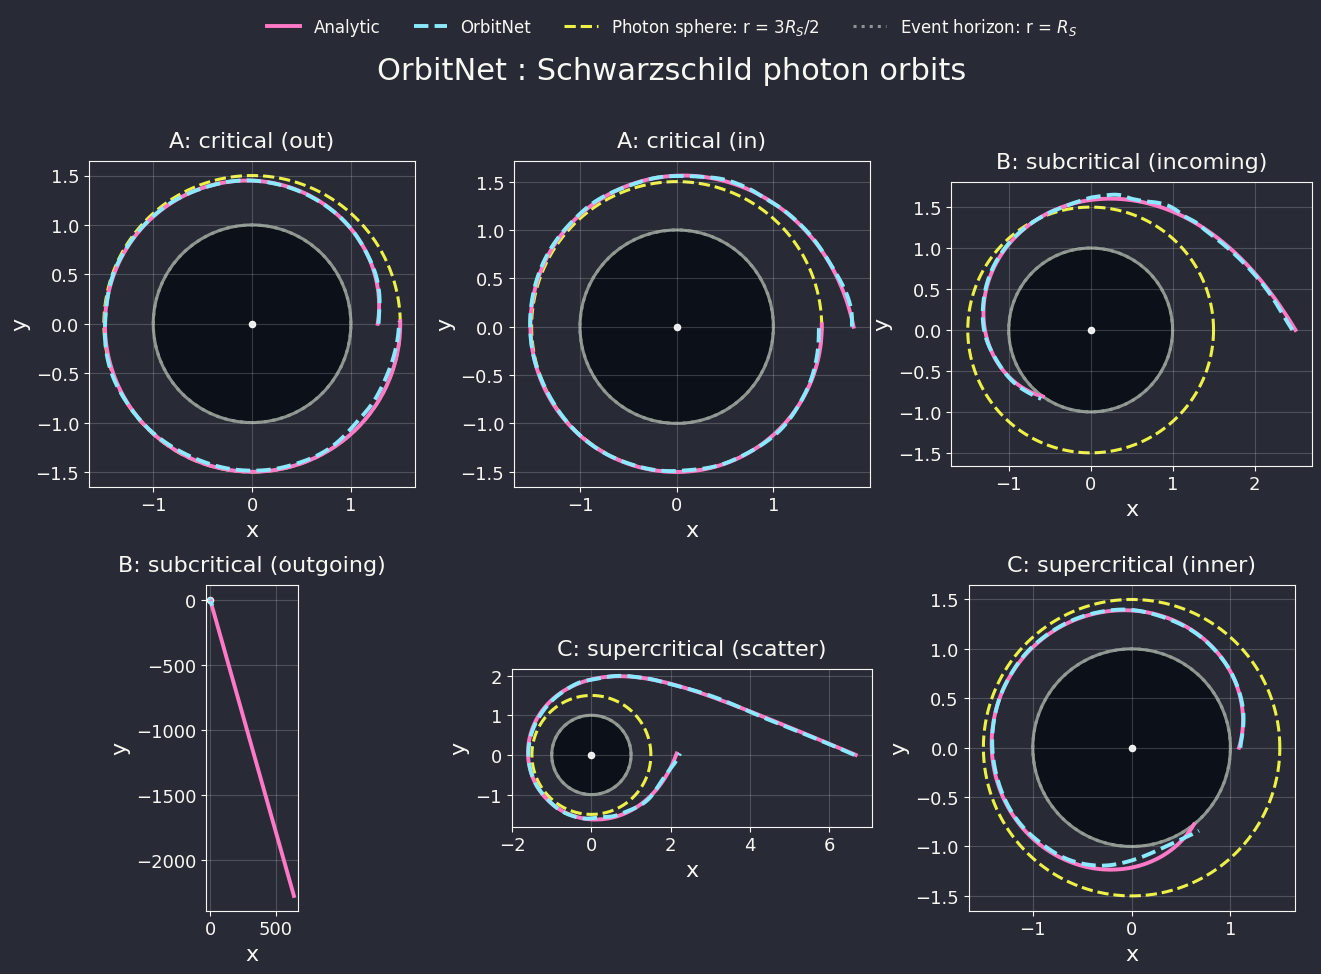

In [24]:
# =========================
# FIXED ORBITS GRID (XY): no title overlap + filled horizon + clean legend
# =========================
import matplotlib.patches as mpatches
C_HORIZON = "#939c95"  # green
C_PHOTON = "#f9fc48"   # yellow
C_ANALYTIC = "#ff79c6"  # pink/magenta
C_MODEL    = "#8be9fd"  # cyan


def draw_reference(ax, Rs=1.0):
    th = np.linspace(0, 2*np.pi, 900)

    # ---- Fill event horizon disk (dark but visible on Dracula)
    # NOTE: not pure black, slightly lighter + alpha for contrast
    horizon_disk = mpatches.Circle(
        (0, 0), Rs,
        facecolor="#0b0f17",  # very dark blue-black (better than pure black on Dracula)
        edgecolor=C_HORIZON,
        linewidth=2.2,
        alpha=0.95,
        zorder=0,
    )
    ax.add_patch(horizon_disk)

    # ---- Photon sphere
    ax.plot(
        1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th),
        ls="--", lw=2.2, color=C_PHOTON, alpha=0.95,
        label="Photon sphere: r = $3R_S/2$",
        zorder=1
    )

    # ---- Optional: horizon edge label entry (legend)
    ax.plot(
        Rs*np.cos(th), Rs*np.sin(th),
        ls=":", lw=2.2, color=C_HORIZON, alpha=0.95,
        label="Event horizon: r = $R_S$",
        zorder=2
    )

    ax.scatter([0],[0], s=20, color="white", alpha=0.9, zorder=3)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.18, color="white")

# --- Build figure with enough top margin for title + legend
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, (name, b, u0, kwargs) in enumerate(cases):
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

    m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
    xT, yT, _ = orbit_xy(phi[m], u_true[m], Rs=Rs)
    xP, yP, _ = orbit_xy(phi[m], u_hat[m], Rs=Rs)

    ax = axes[i]
    ax.plot(xT, yT, color=C_ANALYTIC, label="Analytic", zorder=5)
    ax.plot(xP, yP, "--", color=C_MODEL, label="OrbitNet", zorder=6)
    draw_reference(ax, Rs=Rs)

    ax.set_title(name, pad=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    

# --- One clean global legend OUTSIDE the axes area (prevents overlap)
# Grab unique handles/labels from the first axis
h, l = axes[0].get_legend_handles_labels()
fig.legend(
    h, l,
    loc="upper center",
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),  # place legend above the suptitle area
)

# --- Suptitle placed slightly lower than legend
fig.suptitle(
    "OrbitNet : Schwarzschild photon orbits",
    y=0.965,  # lower => avoids legend
    fontsize=22
)

# --- Manual spacing to guarantee no clipping/overlap
fig.subplots_adjust(top=0.86, wspace=0.22, hspace=0.30)

# Optional save
out1 = os.path.join(OUT_FIGS, f"IG_orbits_grid_{exp_id}_fixed.png")
fig.savefig(out1, dpi=220, bbox_inches="tight")

plt.show()


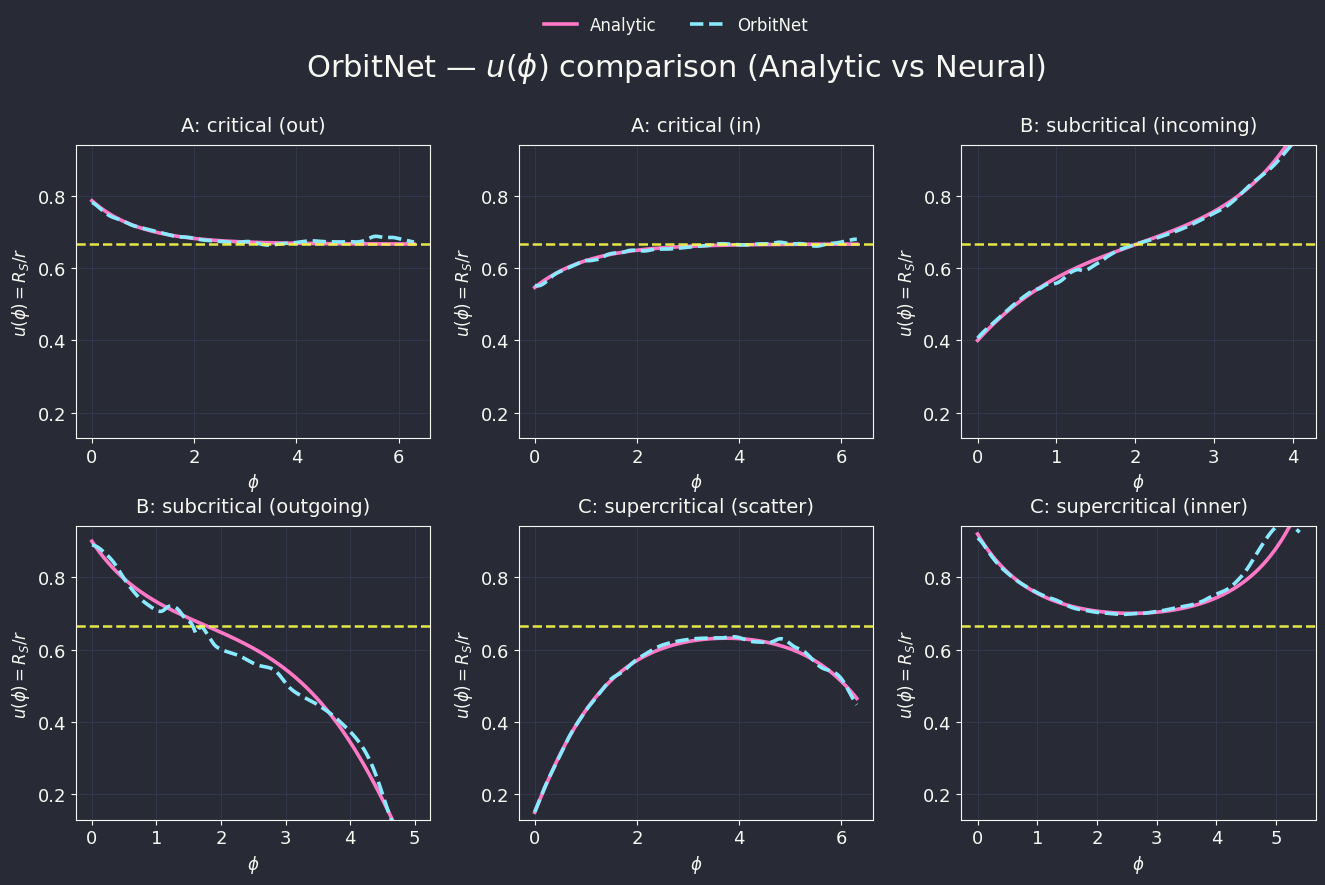

In [23]:
# =========================
# FIX u(phi) GRID (2x3): clean titles + consistent y-lims + no clipping
# =========================
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.ravel()

# Global y-limits (optional) to make comparison easy
# Compute from analytic where finite & physical
u_all = []
for (name, b, u0, kwargs) in cases:
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_all.append(u_true[np.isfinite(u_true) & (u_true > 0)])
u_all = np.concatenate(u_all) if len(u_all) else np.array([0.0])
ymin, ymax = max(0.0, np.nanpercentile(u_all, 1)), min(1.05, np.nanpercentile(u_all, 99))

for i, (name, b, u0, kwargs) in enumerate(cases):
    u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
    u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

    m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)

    ax = axes[i]
    ax.plot(phi[m], u_true[m], lw=2.6, color=C_ANALYTIC, label="Analytic")
    ax.plot(phi[m], u_hat[m],  lw=2.6, ls="--", color=C_MODEL, label="OrbitNet")

    # reference levels
    ax.axhline(2/3, ls="--", lw=1.8, color=C_PHOTON, alpha=0.9)
    ax.axhline(1.0, ls=":",  lw=1.6, color=C_HORIZON, alpha=0.85)

    ax.set_title(name, pad=10, fontsize=14)
    ax.set_xlabel(r"$\phi$", fontsize=12)
    ax.set_ylabel(r"$u(\phi)=R_S/r$", fontsize=12)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.18)

# one global legend (clean)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

fig.suptitle("OrbitNet — $u(\\phi)$ comparison (Analytic vs Neural)", y=0.965, fontsize=22)
fig.subplots_adjust(top=0.86, wspace=0.25, hspace=0.30)

# Optional save
out_u = os.path.join(OUT_FIGS, f"IG_uphi_grid_{exp_id}.png")
fig.savefig(out_u, dpi=220, bbox_inches="tight")

plt.show()


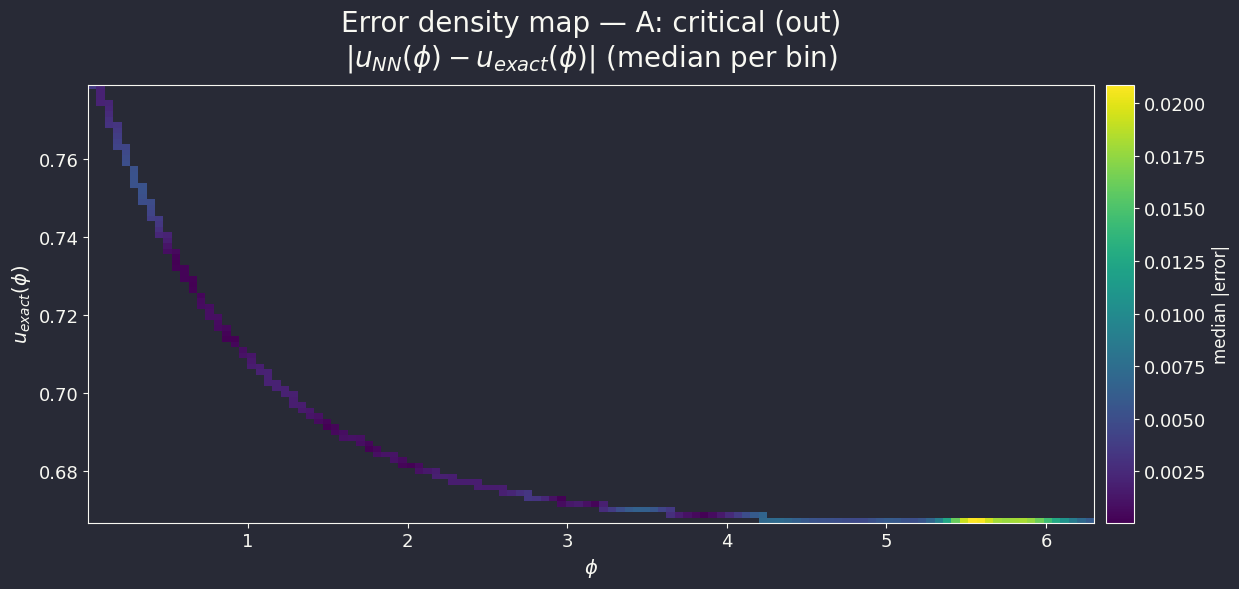

In [17]:
# =========================
# ERROR DENSITY MAP: |u_hat - u_true| in (phi, u_true) space
# =========================
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pick a showcase case (you can loop if you want multiple)
showcase = cases[0]  # e.g. ("A_crit_out", ...)
name, b, u0, kwargs = showcase

u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
phi_m = phi[m]
ut_m = u_true[m]
err = np.abs(u_hat[m] - u_true[m])

fig, ax = plt.subplots(figsize=(12.5, 6))

# 2D binning with median error per bin (robust)
xbins = 120
ybins = 80

# Build bins
x_edges = np.linspace(phi_m.min(), phi_m.max(), xbins + 1)
y_edges = np.linspace(max(0.0, np.nanpercentile(ut_m, 1)), min(1.0, np.nanpercentile(ut_m, 99)), ybins + 1)

# Digitize
xi = np.clip(np.digitize(phi_m, x_edges) - 1, 0, xbins - 1)
yi = np.clip(np.digitize(ut_m,  y_edges) - 1, 0, ybins - 1)

# Aggregate: median error per cell
grid = np.full((ybins, xbins), np.nan, dtype=float)
for yy in range(ybins):
    for xx in range(xbins):
        sel = (xi == xx) & (yi == yy)
        if np.any(sel):
            grid[yy, xx] = np.median(err[sel])

im = ax.imshow(
    grid,
    origin="lower",
    aspect="auto",
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    interpolation="nearest",
)

ax.set_title(f"Error density map — {name}\n$|u_{{NN}}(\\phi)-u_{{exact}}(\\phi)|$ (median per bin)", fontsize=20, pad=14)
ax.set_xlabel(r"$\phi$", fontsize=14)
ax.set_ylabel(r"$u_{exact}(\phi)$", fontsize=14)
ax.grid(False)

# Perfect colorbar placement
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.8%", pad=0.12)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("median |error|", fontsize=12)

fig.tight_layout()

# Optional save
# out_err = os.path.join(OUT_FIGS, f"IG_error_density_{exp_id}_{name}.png")
# fig.savefig(out_err, dpi=240, bbox_inches="tight")

plt.show()


NameError: name 'width' is not defined

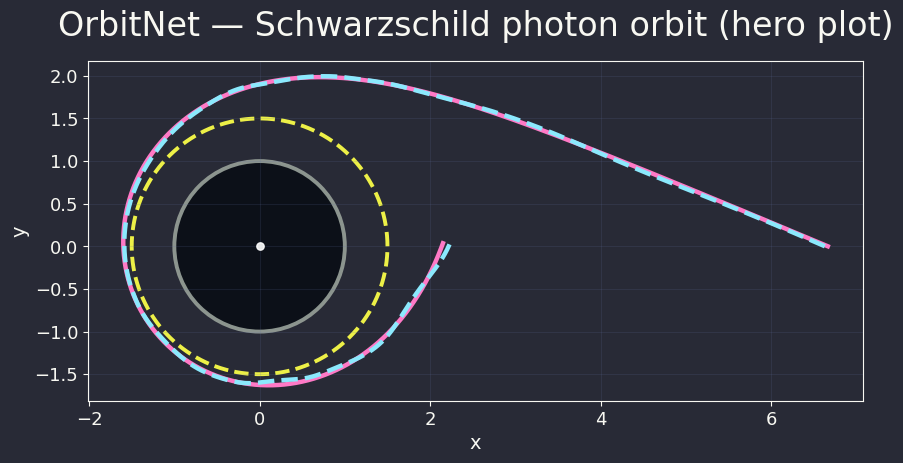

In [18]:
# =========================
# HERO POSTER ORBIT: big title + annotations + clean look
# =========================
import matplotlib.patches as mpatches

hero = ("C_scatter",)  # change to your favorite: "A_crit_out", "B_incoming", "C_inner", ...
hero_case = None
for c in cases:
    if c[0] == hero[0]:
        hero_case = c
        break
if hero_case is None:
    hero_case = cases[4]  # fallback

name, b, u0, kwargs = hero_case

u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)
m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)

xT, yT, rT = orbit_xy(phi[m], u_true[m], Rs=Rs)
xP, yP, rP = orbit_xy(phi[m], u_hat[m], Rs=Rs)

fig, ax = plt.subplots(figsize=(10, 10))

# Filled horizon disk
horizon_disk = mpatches.Circle((0,0), Rs, facecolor="#0b0f17", edgecolor=C_HORIZON, linewidth=2.8, alpha=0.95, zorder=0)
ax.add_patch(horizon_disk)

# Photon sphere circle
th = np.linspace(0, 2*np.pi, 900)
ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th), ls="--", lw=2.8, color=C_PHOTON, alpha=0.95, zorder=1)

# Orbits
ax.plot(xT, yT, lw=3.2, color=C_ANALYTIC, label="Analytic orbit", zorder=5)
ax.plot(xP, yP, lw=3.2, ls="--", color=C_MODEL, label="OrbitNet (NN)", zorder=6)

ax.scatter([0],[0], s=28, color="white", alpha=0.9, zorder=7)

ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title("OrbitNet — Schwarzschild photon orbit (hero plot)", fontsize=24, pad=18)
ax.text(0.02, 0.98, f"Case: {name} | exp={exp_id}\nK={K}, width={width}, depth={depth}, tf={TARGET_TF}",
        transform=ax.transAxes, va="top", ha="left", fontsize=12)

# Annotations (choose points on circles)
ax.annotate(
    "Event horizon\n$r=R_S$",
    xy=(Rs, 0), xycoords="data",
    xytext=(1.15*Rs, -0.55*Rs), textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=2.2, color=C_HORIZON),
    fontsize=14,
    color=C_HORIZON
)

ax.annotate(
    "Photon sphere\n$r=3R_S/2$",
    xy=(1.5*Rs, 0), xycoords="data",
    xytext=(1.65*Rs, 0.65*Rs), textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=2.2, color=C_PHOTON),
    fontsize=14,
    color=C_PHOTON
)

# Legend outside (prevents covering)
ax.legend(loc="upper right", frameon=False, fontsize=13)

fig.tight_layout()

# Optional save
# out_hero = os.path.join(OUT_FIGS, f"IaG_hero_orbit_{exp_id}_{name}.png")
# fig.savefig(out_hero, dpi=260, bbox_inches="tight")

plt.show()


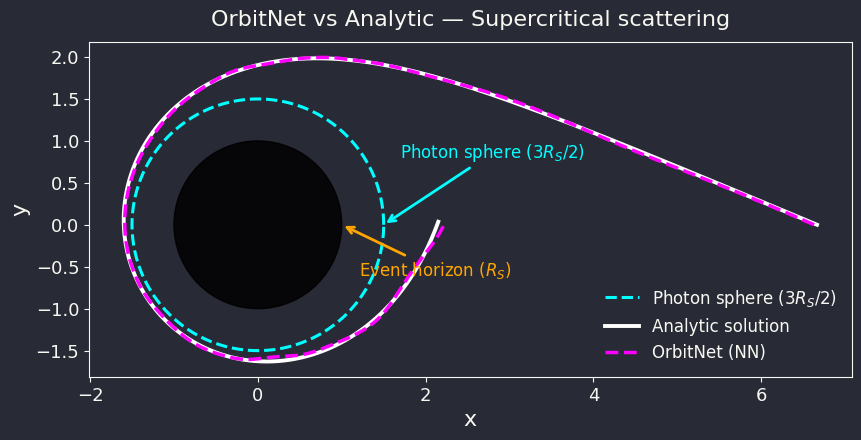

In [22]:
# =========================================================
# HERO SHOT (clean, corrected)
# =========================================================
hero_name, hero_b, hero_u0, hero_kwargs = cases[4]  # C_scatter
u_true, _ = u_phi_general(phi, Rs=Rs, b=hero_b, u0=hero_u0, phi0=0.0, **hero_kwargs)
u_hat = predict_u(model, phi, hero_u0, hero_b, Rs=Rs, K=K,
                  add_valid_flag=ADD_VALID_FLAG,
                  target_transform=TARGET_TF)

m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
xT, yT, _ = orbit_xy(phi[m], u_true[m], Rs=Rs)
xP, yP, _ = orbit_xy(phi[m], u_hat[m], Rs=Rs)

fig, ax = plt.subplots(figsize=(8.5, 8.5), constrained_layout=True)

# --- Filled event horizon (black disk)
circle = plt.Circle((0, 0), Rs, color="black", alpha=0.85, zorder=0)
ax.add_patch(circle)

# --- Photon sphere
th = np.linspace(0, 2*np.pi, 800)
ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th),
        ls="--", lw=2.2, color="cyan", label="Photon sphere ($3R_S/2$)")

# --- Orbits
ax.plot(xT, yT, color="white", lw=2.8, label="Analytic solution")
ax.plot(xP, yP, "--", color="magenta", lw=2.5, label="OrbitNet (NN)")

# --- Arrows
ax.annotate("Event horizon ($R_S$)",
            xy=(Rs, 0), xytext=(1.2*Rs, -0.6*Rs),
            arrowprops=dict(arrowstyle="->", lw=2, color="orange"),
            color="orange", fontsize=12)

ax.annotate("Photon sphere ($3R_S/2$)",
            xy=(1.5*Rs, 0), xytext=(1.7*Rs, 0.8*Rs),
            arrowprops=dict(arrowstyle="->", lw=2, color="cyan"),
            color="cyan", fontsize=12)

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("OrbitNet vs Analytic — Supercritical scattering", pad=12)
ax.legend(frameon=False)

plt.show()

# Optional save
out_hero = os.path.join(OUT_FIGS, f"IaG_hero_orbit_{exp_id}_{name}.png")
fig.savefig(out_hero, dpi=260, bbox_inches="tight")

/tmp/ipykernel_11421/3108295390.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.96])


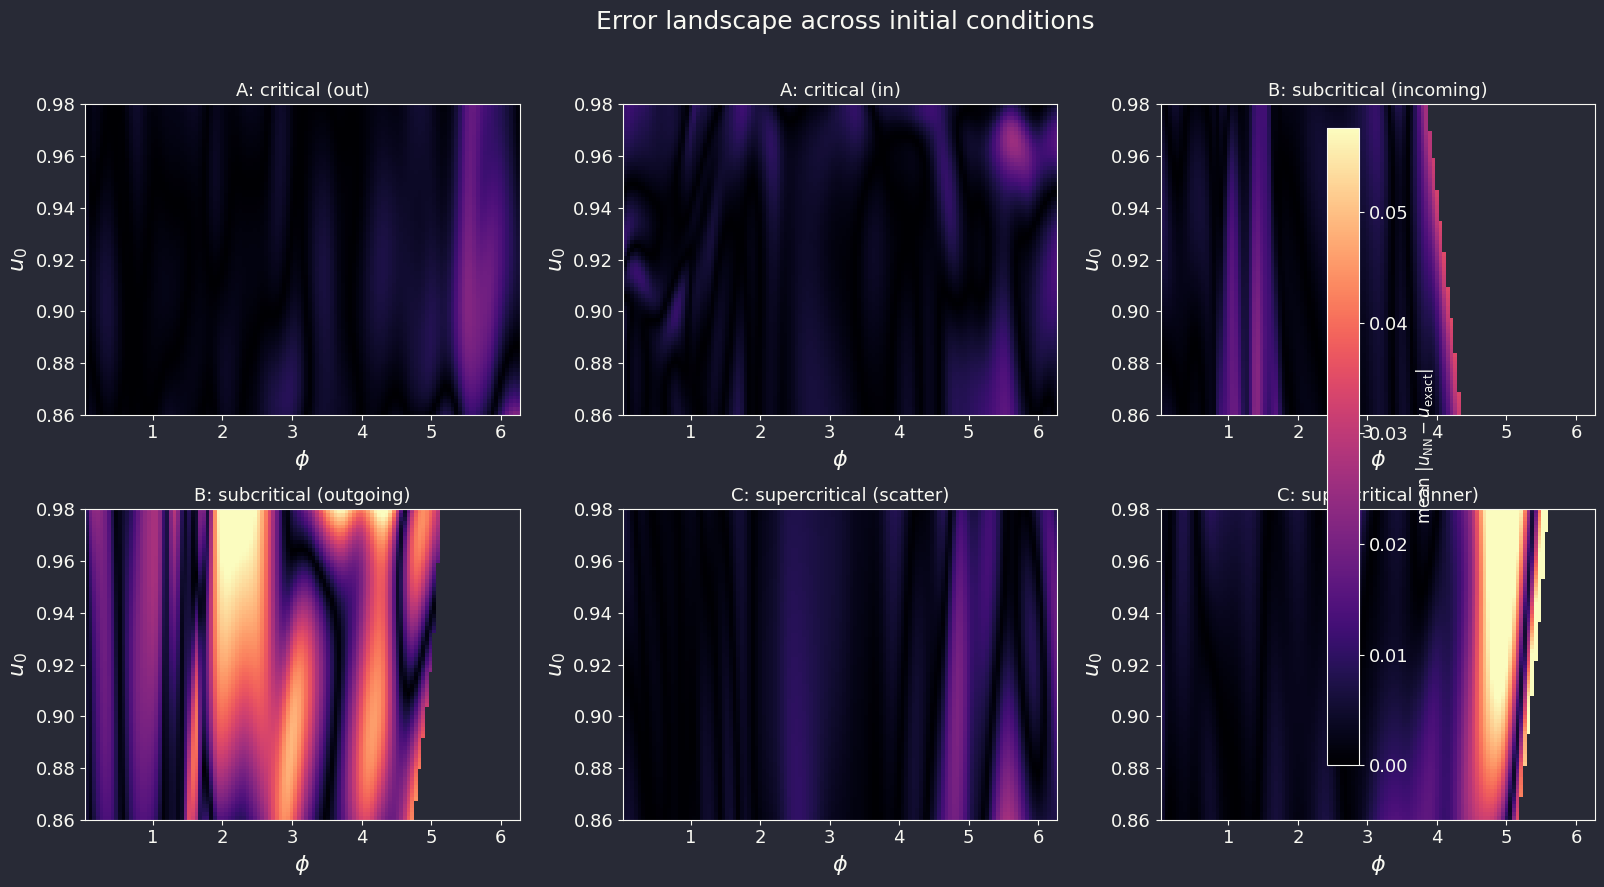

In [21]:
# =========================================================
# (3) ERROR HEATMAPS — corrected & robust
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(17, 9))
axes = axes.ravel()

phi_bins = np.linspace(phi.min(), phi.max(), 120)
phi_cent = 0.5*(phi_bins[:-1] + phi_bins[1:])

all_vals = []  # collect all errors for robust scaling

heatmaps = []

for i, (name, b, u0_nom, kwargs) in enumerate(cases):
    if "critical" in name.lower():
        du = 0.06
    elif "inner" in name.lower():
        du = 0.04
    else:
        du = 0.10

    u0_grid = np.linspace(max(0.02, u0_nom-du),
                          min(0.98, u0_nom+du), 80)

    E = np.full((len(u0_grid), len(phi_cent)), np.nan)

    for j, u0 in enumerate(u0_grid):
        try:
            u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0,
                                      phi0=0.0, **kwargs)
        except Exception:
            continue

        u_hat = predict_u(model, phi, u0, b, Rs=Rs,
                          K=K,
                          add_valid_flag=ADD_VALID_FLAG,
                          target_transform=TARGET_TF)

        m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
        if m.sum() < 80:
            continue

        err = np.abs(u_hat[m] - u_true[m])
        phm = phi[m]

        for kbin in range(len(phi_cent)):
            lo, hi = phi_bins[kbin], phi_bins[kbin+1]
            mm = (phm >= lo) & (phm < hi)
            if mm.any():
                val = float(np.mean(err[mm]))
                E[j, kbin] = val
                all_vals.append(val)

    heatmaps.append(E)

# Robust scaling (global)
vmax = np.nanpercentile(all_vals, 99) if all_vals else 1e-3

for i, E in enumerate(heatmaps):
    ax = axes[i]

    im = ax.imshow(
        np.clip(E, 0, vmax),
        origin="lower",
        aspect="auto",
        extent=[phi_cent.min(), phi_cent.max(),
                u0_grid.min(), u0_grid.max()],
        interpolation="nearest",
        cmap="magma",
        vmin=0,
        vmax=vmax
    )

    ax.set_title(cases[i][0], fontsize=13)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$u_0$")
    ax.grid(False)

# Shared colorbar (stable placement)
cbar = fig.colorbar(im, ax=axes.tolist(),
                    shrink=0.92,
                    location="right",
                    pad=0.02)
cbar.set_label(r"mean $|u_{\rm NN}-u_{\rm exact}|$", fontsize=12)

fig.suptitle("Error landscape across initial conditions",
             fontsize=18, y=0.98)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.show()


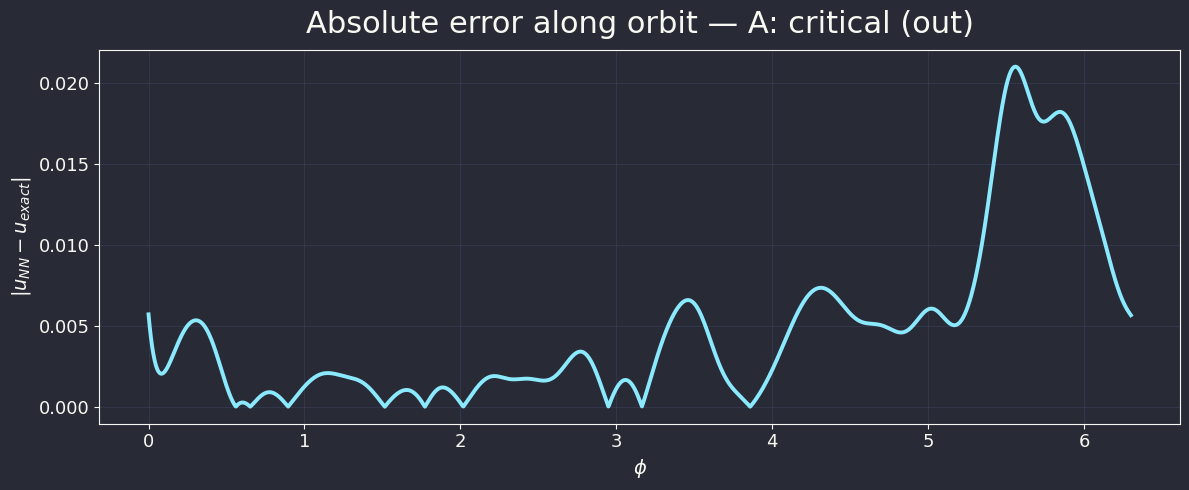

In [27]:
# =========================
# ERROR CURVE: |u_hat - u_true| vs phi (pretty)
# =========================
name, b, u0, kwargs = cases[0]  # choose
u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0, **kwargs)
u_hat = predict_u(model, phi, u0, b, Rs=Rs, K=K, add_valid_flag=ADD_VALID_FLAG, target_transform=TARGET_TF)

m = np.isfinite(u_true) & (u_true > 0) & np.isfinite(u_hat) & (u_hat > 0)
e = np.abs(u_hat[m] - u_true[m])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(phi[m], e, lw=2.8, color=C_MODEL)
ax.set_title(f"Absolute error along orbit — {name}", fontsize=22, pad=12)
ax.set_xlabel(r"$\phi$", fontsize=14)
ax.set_ylabel(r"$|u_{NN} - u_{exact}|$", fontsize=14)
ax.grid(True, alpha=0.18)

# optional log scale (comment/uncomment)
# ax.set_yscale("log")

fig.tight_layout()

# Optional save
# out_ec = os.path.join(OUT_FIGS, f"IG_error_curve_{exp_id}_{name}.png")
# fig.savefig(out_ec, dpi=240, bbox_inches="tight")

plt.show()


In [3]:
# resumen mean±std
def mean_std(x):
    x = np.asarray(x, float)
    mu = x.mean()
    sd = x.std(ddof=1) if len(x) > 1 else 0.0
    return mu, sd

mu_mse, sd_mse = mean_std(df["test_mse"])
mu_val, sd_val = mean_std(df["best_val"])

summary = pd.DataFrame({
    "metric": ["test_mse", "best_val"],
    "mean": [mu_mse, mu_val],
    "std":  [sd_mse, sd_val],
})
summary_path = os.path.join(TABDIR, "retrain_summary_mean_std.csv")
summary.to_csv(summary_path, index=False)

perseed_cols = ["exp_id","seed","test_mse","best_val","width","depth","lambda_pinn","init_lr","batch","weight_decay"]
perseed = df[perseed_cols].copy()
perseed_path = os.path.join(TABDIR, "retrain_per_seed_clean.csv")
perseed.to_csv(perseed_path, index=False)

print("Wrote:", summary_path)
print("Wrote:", perseed_path)
summary


NameError: name 'df' is not defined

# 2. Curvas de entrenamiento (train/val) y schedule de LR

Cada checkpoint (`best_re27_seedXXX.pt`) guarda:
- `train_hist`, `val_hist`, `lr_hist`
- `best_val_loss`, `epoch`, etc.

Esto permite comparar estabilidad entre seeds y detectar overfitting/plateaus.


In [4]:
def load_ckpt(path):
    return torch.load(path, map_location="cpu")

def plot_curves_for_seed(exp_id, ckpt):
    tr = ckpt["train_hist"]
    va = ckpt["val_hist"]
    lr = ckpt["lr_hist"]
    best = ckpt["best_val_loss"]
    ep_best = ckpt["epoch"]

    # train/val
    plt.figure(figsize=(7,4))
    plt.plot(tr, label="train")
    plt.plot(va, label="val")
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("MSE (target space)")
    plt.title(f"Learning curves — {exp_id} | best_val={best:.3e} @ ep={ep_best}")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    f1 = os.path.join(OUTDIR, f"curve_trainval_{exp_id}.png")
    plt.savefig(f1, dpi=180)
    plt.close()

    # lr
    plt.figure(figsize=(7,3.5))
    plt.plot(lr)
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("lr")
    plt.title(f"LR schedule — {exp_id}")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    f2 = os.path.join(OUTDIR, f"curve_lr_{exp_id}.png")
    plt.savefig(f2, dpi=180)
    plt.close()

    return f1, f2

curve_files = []
for _, row in df.iterrows():
    exp_id = row["exp_id"]
    ckpt_path = row["ckpt_path"]
    ckpt = load_ckpt(ckpt_path)
    curve_files += list(plot_curves_for_seed(exp_id, ckpt))

print("Saved curves:", len(curve_files))


NameError: name 'df' is not defined

# 3. Validación física: casos A/B/C

Usamos los escenarios estándar del proyecto:

- A_crit_out: b=bcrit, u0=2/3+0.12 (rama exterior crítica)
- A_crit_in : b=bcrit, u0=2/3-0.12 (rama interior crítica)
- B_incoming / B_outgoing: b=0.98 bcrit
- C_scatter / C_inner: b=1.004 bcrit

Comparación:
- Solución analítica `u_phi_general`
- Predicción NN `predict_u` (con K=8, add_valid_flag=1, target_transform=log1p)

Además, graficamos órbitas $x(\phi),y(\phi)$ usando $r = R_S/u$.


In [5]:
# importa tu código local
import sys
sys.path.append(os.path.join(BASE, "code"))

from orbit_emulator import (
    load_model_from_ckpt,
    bcrit,
    u_phi_general,
    predict_u
)

def orbit_xy(phi, u, Rs=1.0):
    phi = np.asarray(phi, float)
    u = np.asarray(u, float)
    r = np.where(np.isfinite(u) & (u > 0), Rs/u, np.nan)
    return r*np.cos(phi), r*np.sin(phi), r

def draw_reference(ax, Rs=1.0):
    th = np.linspace(0, 2*np.pi, 600)
    ax.plot(Rs*np.cos(th), Rs*np.sin(th), ":", lw=1, label="r = Rs")
    ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th), "--", lw=1, label="r = 3Rs/2")
    ax.scatter([0],[0], s=15)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25)

def make_cases(Rs=1.0):
    bc = bcrit(Rs)
    return [
        ("A_crit_out", bc, 2/3 + 0.12, dict(branch=None, region=None)),
        ("A_crit_in",  bc, 2/3 - 0.12, dict(branch=None, region=None)),
        ("B_incoming", 0.98*bc, 0.40, dict(branch="incoming", region=None)),
        ("B_outgoing", 0.98*bc, 0.90, dict(branch="outgoing", region=None)),
        ("C_scatter",  1.004*bc, 0.15, dict(branch=None, region="scatter")),
        ("C_inner",    1.004*bc, 0.92, dict(branch=None, region="inner")),
    ]


ModuleNotFoundError: No module named 'orbit_emulator'